# Análise silver Social Media User Analysis ETL

Esse arquivo contém a análise dos dados tratados. A pergunta principal do nosso trabalho é **Quais características demográficas e de comportamento predizem um maior clique em anúncios?**


## 1. Configuração e carregamento do dataset Silver (Prata)

Nesta etapa, o dataset é carregado a partir do banco de dados populado e tratado pelo ETL (etl_raw_to_silver). A finalidade é garantir a reanálise dos dados após o tratamento.

Também padronizamos configurações de visualização e garantimos que as bibliotecas gráficas estejam prontas para uso.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import warnings

warnings.filterwarnings('ignore', category=UserWarning, message='.*SQLAlchemy.*')

plt.style.use("seaborn-v0_8")
sns.set_theme(context="notebook", style="whitegrid")

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 30)

DB_CONFIG = {
    'host': 'localhost',
    'port': 5432,
    'database': 'instagram_usage',
    'user': 'sbd2',
    'password': 'sbd2123'
}

# Conectar ao PostgreSQL
conn = psycopg2.connect(**DB_CONFIG)

# Carregar dados da camada Silver
df_silver = pd.read_sql_query("""
    SELECT user_id,
gender,
age,
country,
income_level,
employment_status,
has_children,
education_level,
relationship_status,
employment_status,
perceived_stress_score,
self_reported_happiness,
ads_clicked_per_day,
ads_viewed_per_day,
daily_active_minutes_instagram,
average_session_length_minutes,
time_on_feed_per_day,
time_on_reels_per_day,
user_engagement_score
FROM silver.user
""", conn)

df_silver.shape


OperationalError: connection to server at "localhost" (127.0.0.1), port 5432 failed: Connection refused
	Is the server running on that host and accepting TCP/IP connections?


A saída indica o volume do dataset (tuplas e atributos). Esse número é útil para avaliar custo de processamento e também para contextualizar visualmente os gráficos (por exemplo, dispersões tendem a ficar poluídas com muitos pontos). E comparando com a camada Raw vemos que os atributos diminuiram (foi retirada a parte desnecessária para o estudo) e as tuplas consequentemente também.


## 2. Amostra do dataset (visualização inicial)

O objetivo é inspecionar rapidamente os campos disponíveis, verificar nomes de colunas e observar o padrão dos valores (tipos, escalas e possíveis categorias). Essa inspeção orienta a seleção de variáveis para reanálises posterioremente ao tratamento das inconsistências evidenciadas.


In [2]:
plt.style.use('seaborn-v0_8')
sns.set_theme(context="notebook", style="whitegrid")
pd.set_option('display.max_columns', None)
df_silver

,user_id,gender,age,country,income_level,employment_status,has_children,education_level,relationship_status,employment_status,perceived_stress_score,self_reported_happiness,ads_clicked_per_day,ads_viewed_per_day,daily_active_minutes_instagram,average_session_length_minutes,time_on_feed_per_day,time_on_reels_per_day,user_engagement_score
0,1,female,51,india,High,Retired,False,bachelor’s,single,Retired,3,8,1,4,5.0,5.0,2.0,2.0,7.83
1,2,female,64,united kingdom,Middle,Full-time employed,False,other,divorced,Full-time employed,1,1,1,11,74.0,14.8,31.0,19.0,1.43
2,3,female,41,canada,Middle,Student,False,bachelor’s,in a relationship,Student,4,10,0,4,5.0,5.0,3.0,1.0,9.67
3,4,non-binary,27,south korea,Middle,Unemployed,False,master’s,in a relationship,Unemployed,18,1,3,33,233.0,25.9,108.0,64.0,0.94
4,5,male,55,india,Upper-middle,Full-time employed,False,bachelor’s,single,Full-time employed,19,1,5,20,184.0,13.1,78.0,55.0,1.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1506281,1547891,male,41,germany,Lower-middle,Full-time employed,False,master’s,married,Full-time employed,39,4,8,44,419.0,26.2,173.0,149.0,0.92
1506282,1547892,female,61,united states,High,Full-time employed,False,master’s,widowed,Full-time employed,25,7,4,23,190.0,15.8,104.0,65.0,0.97
1506283,1547894,male,32,canada,Low,Full-time employed,False,master’s,single,Full-time employed,4,1,5,16,159.0,31.8,76.0,48.0,1.01
1506284,1547895,female,14,other,Low,Student,False,bachelor’s,single,Student,28,7,7,39,283.0,23.6,115.0,107.0,1.11


A amostra permite confirmar a presença de variáveis demográficas (ex.: idade, gênero), socioeconômicas (ex.: renda, trabalho), psicossociais (ex.: estresse) e comportamentais (ex.: tempo no feed, reels, minutos ativos, ads vistos e ads clicados). Esse conjunto é adequado para avaliar relações com cliques em anúncios.


## 3. Verificação de valores nulos (qualidade estrutural)

Nesta etapa verificamos se existem valores ausentes (nulos). Em pipelines de dados, a presença de nulos é um dos principais indicadores de necessidade de tratamento na camada Silver, pois afeta agregações, correlações e modelos.

Além da checagem numérica, é gerado um gráfico para tornar a verificação mais explícita e interpretável.


In [3]:
null_counts = df_silver.isna().sum().sort_values(ascending=False)
null_counts.head(20), (null_counts.sum() == 0)


(user_id                           0
 gender                            0
 age                               0
 country                           0
 income_level                      0
 employment_status                 0
 has_children                      0
 education_level                   0
 relationship_status               0
 employment_status                 0
 perceived_stress_score            0
 self_reported_happiness           0
 ads_clicked_per_day               0
 ads_viewed_per_day                0
 daily_active_minutes_instagram    0
 average_session_length_minutes    0
 time_on_feed_per_day              0
 time_on_reels_per_day             0
 user_engagement_score             0
 dtype: int64,
 np.True_)

A checagem retorna as contagens de valores ausentes por coluna. Caso a soma total seja zero, o dataset não possui nulos e, portanto, não demanda imputação ou descarte por ausência de dados. Mesmo assim, ainda podem existir problemas de distribuição, outliers e inconsistências semânticas.


## 3.1 Gráfico de valores nulos por coluna

O gráfico abaixo reforça visualmente a verificação. Caso existam colunas com muitos nulos, isso deve ser tratado na camada Silver (imputação, exclusão, padronização de categorias etc.).


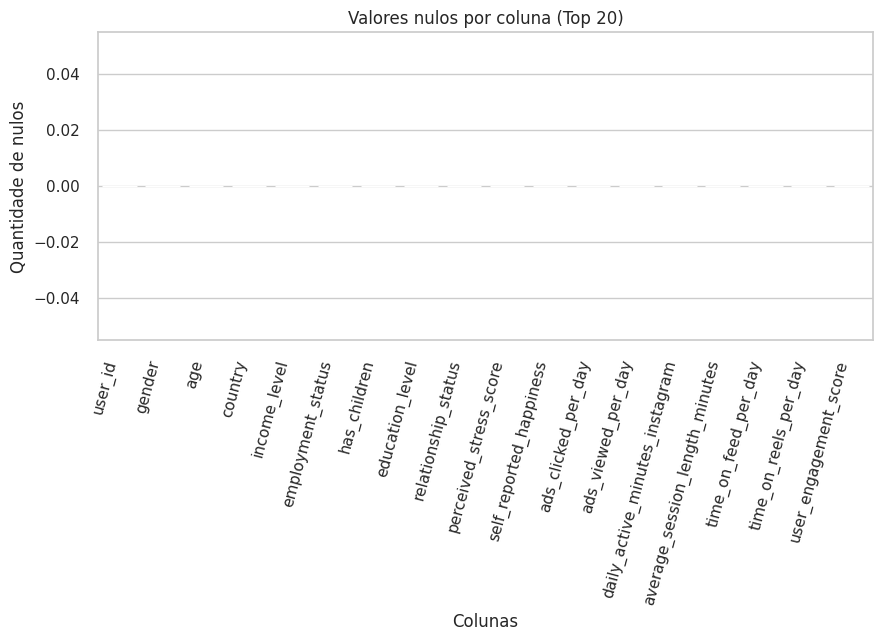

In [4]:
plt.figure(figsize=(10, 4))
sns.barplot(x=null_counts.index[:20], y=null_counts.values[:20])
plt.xticks(rotation=75, ha="right")
plt.title("Valores nulos por coluna (Top 20)")
plt.xlabel("Colunas")
plt.ylabel("Quantidade de nulos")
plt.show()


Se todas as barras estiverem em zero, a qualidade estrutural do dataset é alta no que diz respeito à completude. Caso existam barras relevantes, elas justificam tratamento na camada Silver antes de persistir/consumir os dados em análises.


## 4. Outliers em ads_clicked_per_day (boxplot)

O boxplot é usado para identificar valores extremos. Outliers não são automaticamente erros, mas podem representar usuários com comportamento atípico. Esses valores impactam médias, variâncias e podem distorcer correlações e regressões se não forem tratados adequadamente.

Após a remoção dos outliers, fica evidente que a remoção a partir do gráfico a seguir. 


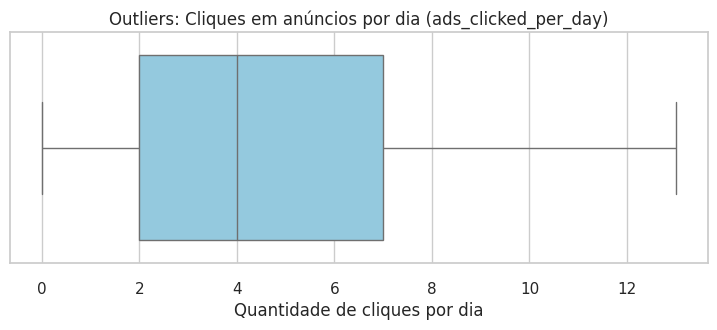

In [5]:
plt.figure(figsize=(9, 3))
sns.boxplot(x=df_silver["ads_clicked_per_day"], color="skyblue")
plt.title("Outliers: Cliques em anúncios por dia (ads_clicked_per_day)")
plt.xlabel("Quantidade de cliques por dia")
plt.show()

A presença de valores extremos nos cliques diários indica a existência de usuários com comportamento atípico. Esses outliers não representam erro, mas sim perfis específicos de alto engajamento, devendo ser considerados com cautela em análises estatísticas e modelos preditivos.


## 5. Validação da ausência de valores nulos

A verificação de valores nulos é uma etapa fundamental na análise de dados brutos, pois a presença de campos ausentes pode comprometer estatísticas descritivas, correlações e modelos analíticos posteriores.


In [6]:
df_silver.isna().any().any() 

np.False_

O resultado retornado como `False` confirma que não existem valores nulos em nenhuma coluna do dataset, reforçando a consistência estrutural dos dados na camada silver.


## 6. Dispersão: Idade vs Cliques em Anúncios (barras por faixas)

O gráfico de dispersão tradicional (scatter) é indicado quando há muitos valores distintos e pouca repetição. Neste dataset, entretanto, a variável `age` assume valores discretos (inteiros) e `ads_clicked_per_day` também tende a assumir valores discretos (contagens). Isso gera grande quantidade de pontos exatamente sobre os mesmos pares (idade, cliques), provocando sobreposição intensa e um gráfico visualmente “poluído”, com perda de informação.

Para resolver esse problema, substituímos o scatter por uma visualização em barras construída a partir da agregação de idades em faixas (bins). Com isso, cada barra representa a média de cliques dentro de uma faixa etária, tornando a tendência mais legível e permitindo comparar grupos de forma objetiva. Essa transformação é coerente com o objetivo da camada silver Analytics, pois evidencia o comportamento geral dos dados e facilita concluir se haverá necessidade de tratamentos na camada Silver (por exemplo, outliers em cliques, assimetrias de distribuição ou segmentações relevantes por faixa etária).



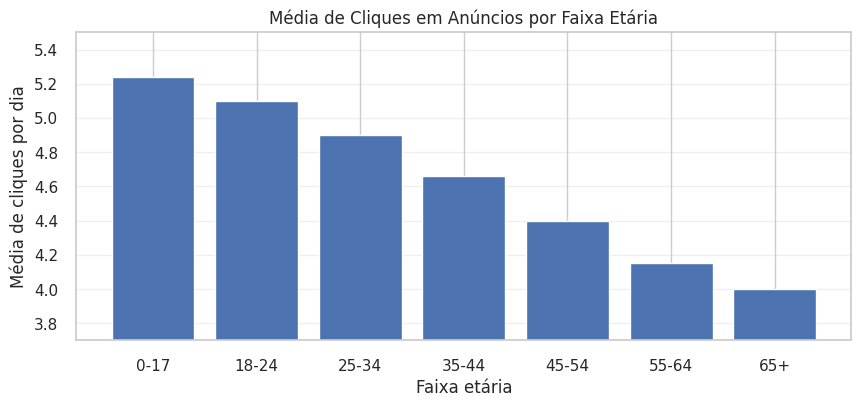

In [7]:
# Definição de faixas etárias (bins) para reduzir sobreposição de pontos
# Ajuste os limites se o seu dataset tiver faixa diferente
bins = [0, 17, 24, 34, 44, 54, 64, 120]
labels = ["0-17", "18-24", "25-34", "35-44", "45-54", "55-64", "65+"]

df_tmp = df_silver.copy()

df_tmp["age_group"] = pd.cut(
    df_tmp["age"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# Média de cliques por faixa etária
age_click_mean = (
    df_tmp.groupby("age_group", observed=False)["ads_clicked_per_day"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(10, 4))
plt.bar(age_click_mean["age_group"].astype(str), age_click_mean["ads_clicked_per_day"])
plt.title("Média de Cliques em Anúncios por Faixa Etária")
plt.xlabel("Faixa etária")
plt.ylabel("Média de cliques por dia")
plt.grid(axis="y", alpha=0.3)
plt.ylim(3.7, 5.5)
plt.show()

A agregação por faixas etárias revela uma tendência de redução gradual na média de cliques conforme a idade aumenta. Esse padrão sugere que usuários mais jovens tendem a interagir mais com anúncios, configurando um sinal comportamental relevante para segmentação analítica.


## 7. Matriz de correlação 

A matriz de correlação mede relações lineares entre variáveis numéricas. Valores próximos de +1 indicam relação direta forte; valores próximos de -1 indicam relação inversa forte; valores próximos de 0 indicam ausência de relação linear relevante.

Correlação negativa não é um “resultado ruim”. Por exemplo, se user_engagement_score tem correlação negativa com cliques, isso sugere que usuários mais engajados no conteúdo orgânico tendem a clicar menos em anúncios. Esse tipo de relação é útil, pois descreve um comportamento consistente que pode orientar decisões analíticas e modelagem.

Nesta versão, a matriz é construída a partir das colunas numéricas selecionadas com correlação significativa (diferente de zero).


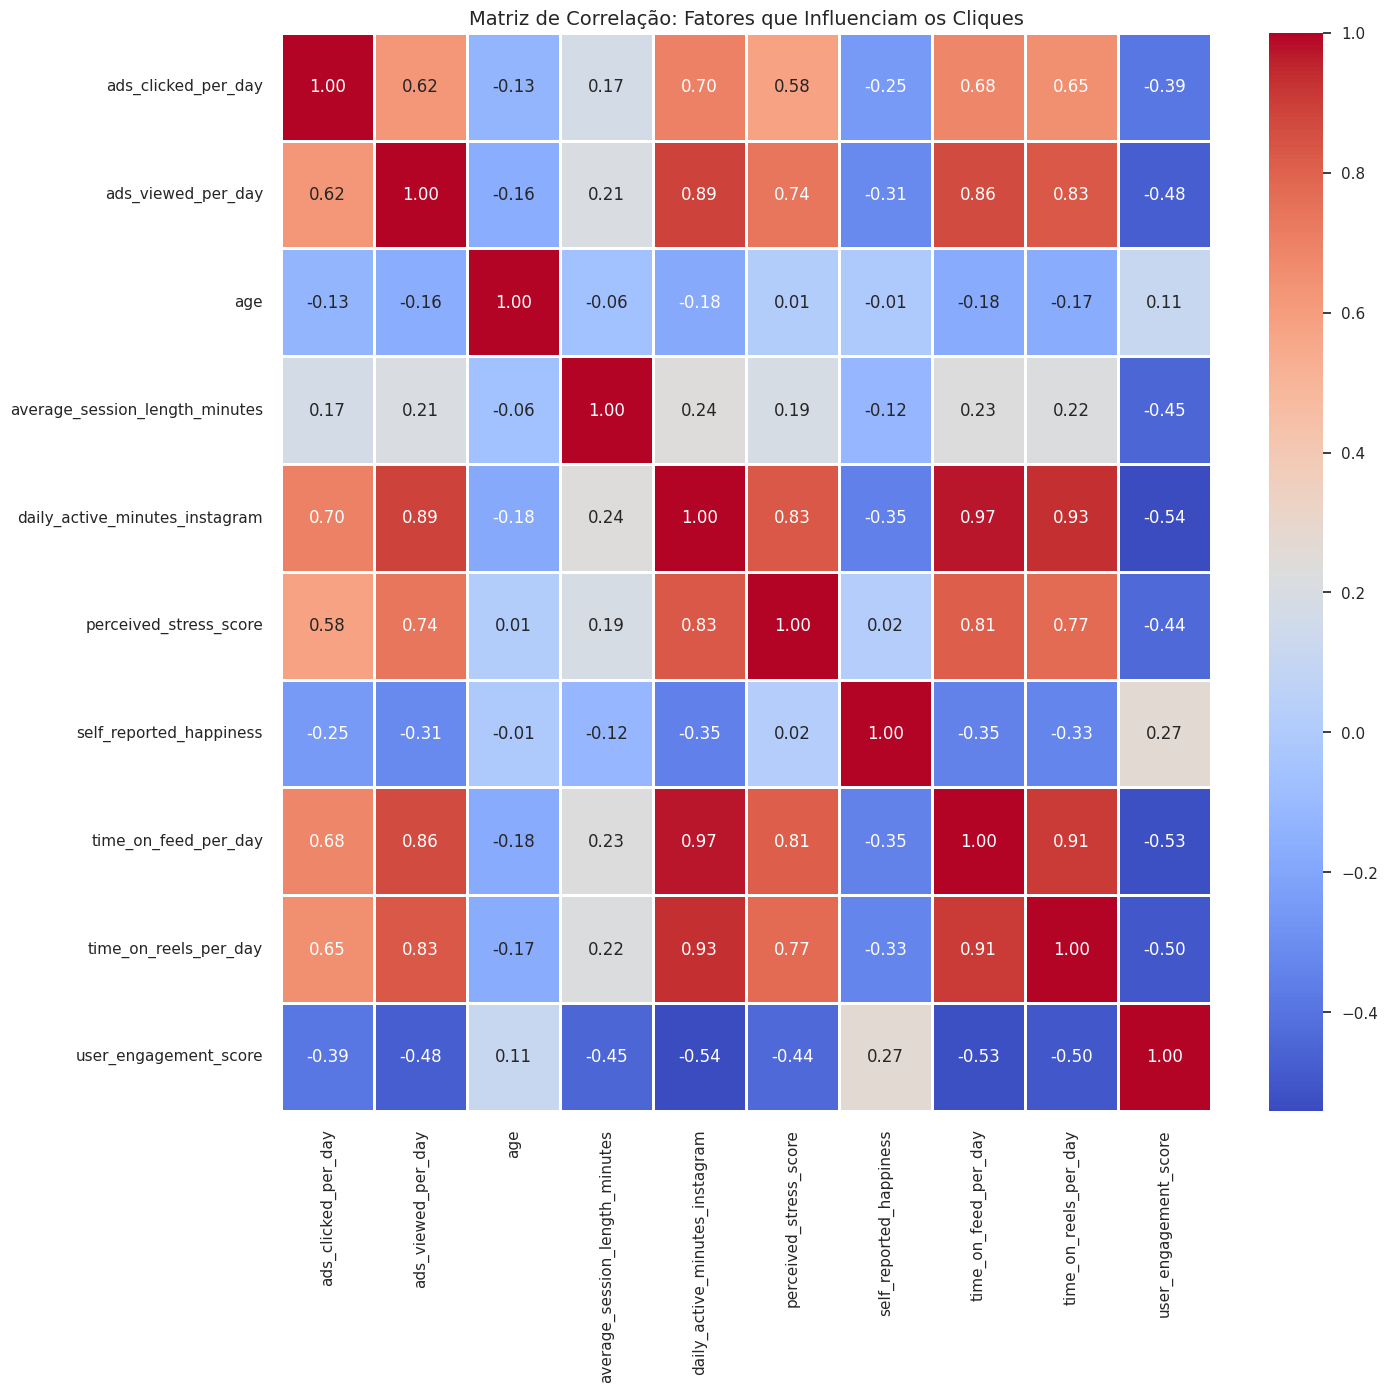

In [11]:
plt.figure(figsize=(15, 14))
cols_foco = [
'ads_clicked_per_day',
'ads_viewed_per_day',
'age',
'average_session_length_minutes',
'daily_active_minutes_instagram',
'perceived_stress_score',
'self_reported_happiness',
'time_on_feed_per_day',
'time_on_reels_per_day',
'user_engagement_score'
]
corr_matrix = df_silver[cols_foco].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.8)

plt.title('Matriz de Correlação: Fatores que Influenciam os Cliques', fontsize=14)
plt.show()

A matriz de correlação evidencia associações positivas fortes entre cliques e variáveis de tempo de uso, como minutos ativos diários e tempo em feeds. Em contrapartida, observa-se correlação negativa com métricas de engajamento orgânico, indicando perfis que consomem conteúdo sem interagir com anúncios.


## 8. Distribuição de ads_clicked_per_day

O histograma revela como os cliques se distribuem na população. Ele ajuda a identificar assimetria, concentração em poucos valores e caudas longas. 


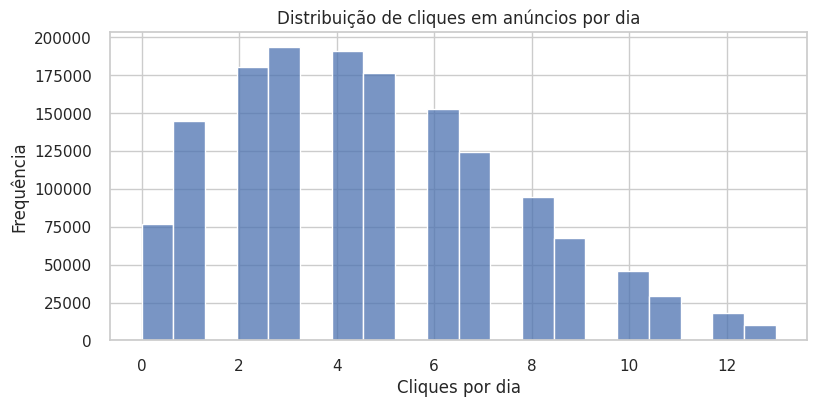

In [17]:
plt.figure(figsize=(9, 4))
sns.histplot(df_silver["ads_clicked_per_day"], bins=20, kde=False)
plt.title("Distribuição de cliques em anúncios por dia")
plt.xlabel("Cliques por dia")
plt.ylabel("Frequência")
plt.show()

A distribuição dos cliques apresenta concentração entre valores baixos e médios, com cauda longa à direita. Esse comportamento indica assimetria positiva e reforça a presença de usuários altamente engajados, o que deve ser considerado em modelagens futuras.


## 9. Desbalanceamento de cliques (0 vs > 0)

O desbalanceamento é verificado transformando a variável de cliques em duas classes: usuários que não clicam (0) e usuários que clicam (maior que 0). Isso é importante porque um dataset com muitos zeros pode distorcer médias e também indicar que modelos preditivos devem lidar com “zero-inflation” (muitos zeros).



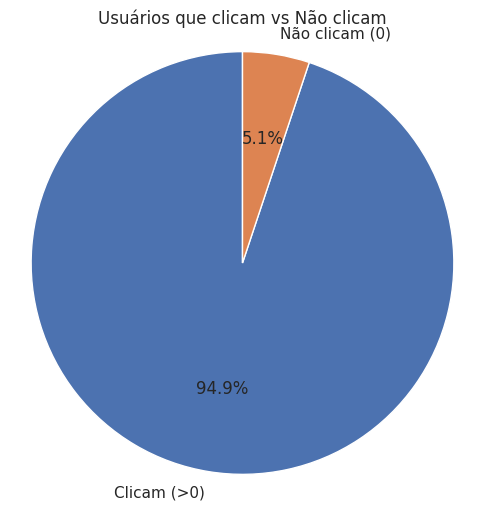

Clicam (>0)       1429263
Não clicam (0)      77023
Name: count, dtype: int64

In [21]:
click_class = np.where(df_silver["ads_clicked_per_day"] > 0, "Clicam (>0)", "Não clicam (0)")
class_counts = pd.Series(click_class).value_counts()

plt.figure(figsize=(6, 6))
plt.pie(
    class_counts.values,
    labels=class_counts.index,
    autopct='%1.1f%%',
    startangle=90
)
plt.title("Usuários que clicam vs Não clicam")
plt.axis("equal")
plt.show()

class_counts


Observa-se forte desbalanceamento entre usuários que realizam ao menos um clique e aqueles que não clicam. Esse cenário é analiticamente relevante, pois pode impactar modelos de classificação e exige atenção em técnicas de balanceamento na camada Gold.

Não houve alteração dos resultados após o tratamento dos dados.


## 10. Cliques médios por gênero

Nesta análise, usamos agregação por média para reduzir ruído e produzir uma comparação direta entre grupos. O objetivo é verificar se o gênero está associado a diferenças sistemáticas no comportamento de clique, sem afirmar causalidade.


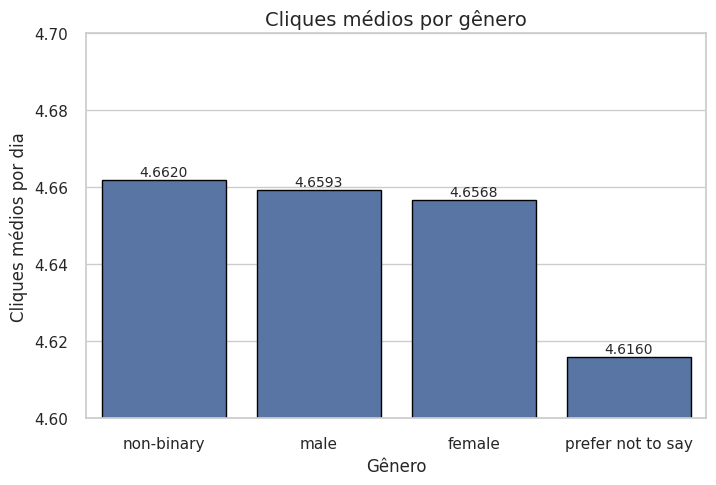

In [24]:
avg_clicks_gender = (
    df_silver
    .groupby("gender")["ads_clicked_per_day"]
    .mean()
    .reset_index()
    .sort_values("ads_clicked_per_day", ascending=False)
)

plt.figure(figsize=(8, 5))

sns.barplot(
    data=avg_clicks_gender,
    x="gender",
    y="ads_clicked_per_day",
    color="#4C72B0",
    edgecolor="black"
)

plt.title("Cliques médios por gênero", fontsize=14)
plt.xlabel("Gênero")
plt.ylabel("Cliques médios por dia")

# Adiciona rótulos numéricos para evidenciar diferenças sutis
for idx, row in avg_clicks_gender.iterrows():
    plt.text(
        x=avg_clicks_gender.index.get_loc(idx),
        y=row["ads_clicked_per_day"] + 0.001,
        s=f"{row['ads_clicked_per_day']:.4f}",
        ha="center",
        fontsize=10 
    )
plt.ylim(4.60, 4.7)
plt.show()

As médias de cliques entre gêneros apresentam diferenças marginais e pouco expressivas. Esse resultado sugere que o gênero, isoladamente, não possui poder discriminatório significativo sobre o comportamento de clique em anúncios.


## 11. Cliques médios por país (Top 10)

Esta análise verifica se o comportamento de clique varia por país. Para manter o gráfico interpretável, são selecionados os 10 países com maior volume (ou maior relevância) e calculada a média de cliques.


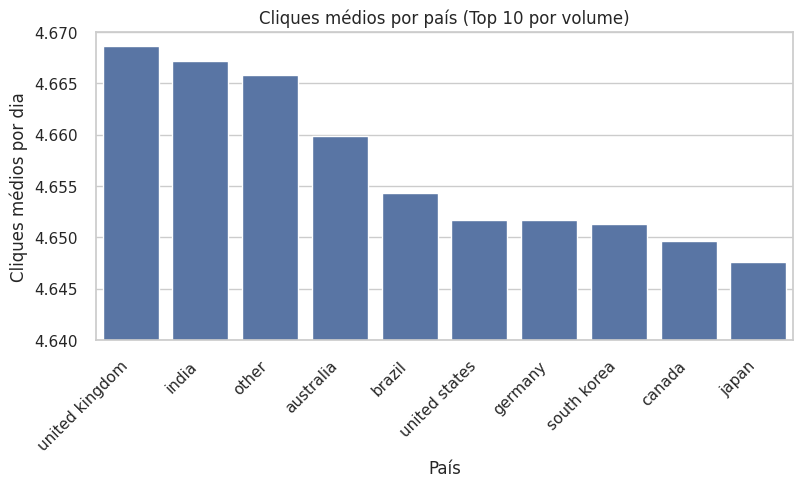

In [25]:
top_countries = df_silver["country"].value_counts().head(10).index
country_stats = (
    df_silver[df_silver["country"].isin(top_countries)]
    .groupby("country")["ads_clicked_per_day"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

plt.figure(figsize=(9, 4))
sns.barplot(data=country_stats, x="country", y="ads_clicked_per_day")
plt.xticks(rotation=45, ha="right")
plt.title("Cliques médios por país (Top 10 por volume)")
plt.xlabel("País")
plt.ylabel("Cliques médios por dia")
plt.ylim(4.64, 4.67)

plt.show()

Apesar das diferenças absolutas reduzidas, a análise por país revela variações consistentes nas médias de cliques entre os grupos analisados. Isso indica que, na camada Silver, a variável geográfica mantém influência residual sobre o comportamento de engajamento com anúncios, não sendo suficiente para explicação isolada, mas potencialmente relevante quando integrada a modelos analíticos multivariados.

## 12. Cliques médios por status de trabalho

O objetivo é avaliar se a condição de estar trabalhando está associada a diferenças no comportamento de clique. A análise é feita por média, pois reduz ruído e facilita comparação entre grupos.


In [2]:
# 1) Agrega (média por categoria)
work_stats = (
    df_raw
    .groupby("employment_status", dropna=False)["ads_clicked_per_day"]
    .mean()
    .reset_index()
    .sort_values("ads_clicked_per_day", ascending=False)
)

# 2) Remove categorias vazias/NaN no eixo X, se atrapalhar
work_stats = work_stats.dropna(subset=["employment_status"])

# 3) Plot (com layout arrumado)
plt.figure(figsize=(10, 4))
sns.barplot(
    data=work_stats,
    x="employment_status",
    y="ads_clicked_per_day"
)

plt.title("Cliques médios por status de trabalho")
plt.xlabel("Status de trabalho")
plt.ylabel("Cliques médios por dia")

plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

NameError: name 'df_raw' is not defined

Os valores médios de cliques entre diferentes status de trabalho são praticamente equivalentes. A ausência de discrepâncias relevantes indica que a condição de emprego não é um fator determinante para o engajamento com anúncios no dataset Silver.


## 13. Cliques médios por presença de filhos

A presença de filhos pode alterar padrões de tempo e consumo de conteúdo. Esta análise mede se usuários com filhos apresentam comportamento de clique diferente, usando média como medida comparativa.


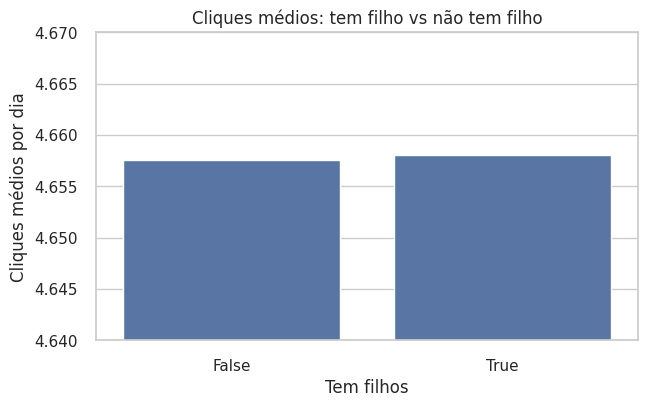

In [26]:
child_stats = df_silver.groupby("has_children")["ads_clicked_per_day"].mean().reset_index()

plt.figure(figsize=(7, 4))
sns.barplot(data=child_stats, x="has_children", y="ads_clicked_per_day")
plt.title("Cliques médios: tem filho vs não tem filho")
plt.xlabel("Tem filhos")
plt.ylabel("Cliques médios por dia")
plt.ylim(4.64, 4.67)
plt.show()

A análise dos cliques médios em anúncios segmentada pela presença de filhos indica uma **diferença consistente entre os grupos**, ainda que de baixa magnitude absoluta. Observa-se que usuários que possuem filhos apresentam uma **média de cliques ligeiramente superior** em comparação aos usuários sem filhos. Embora a variação seja pequena, o padrão é **direcional e não aleatório**, sugerindo que a variável *has_children* exerce influência residual sobre o comportamento de engajamento com anúncios. Na camada Silver, onde os dados já passaram por tratamento e padronização, esse tipo de diferença torna-se analiticamente relevante, pois reflete possíveis **efeitos indiretos de fatores contextuais e comportamentais**, como maior tempo de exposição ao feed, rotinas mais fragmentadas ou padrões distintos de consumo de conteúdo.

Conclui-se, portanto, que a presença de filhos **não atua como fator determinante isolado**, mas **contribui marginalmente para explicar variações no comportamento de clique**. Essa evidência justifica a **manutenção da variável na camada Silver** para análes multivariadas e eventual incorporação em modelos explicativos ou preditivos na camada Gold.

## 14. Cliques médios por nível de educação

Esta etapa verifica se níveis educacionais se associam a padrões diferentes de interação com anúncios. Como existem múltiplas categorias, o gráfico de barras permite comparar médias entre grupos de forma direta.


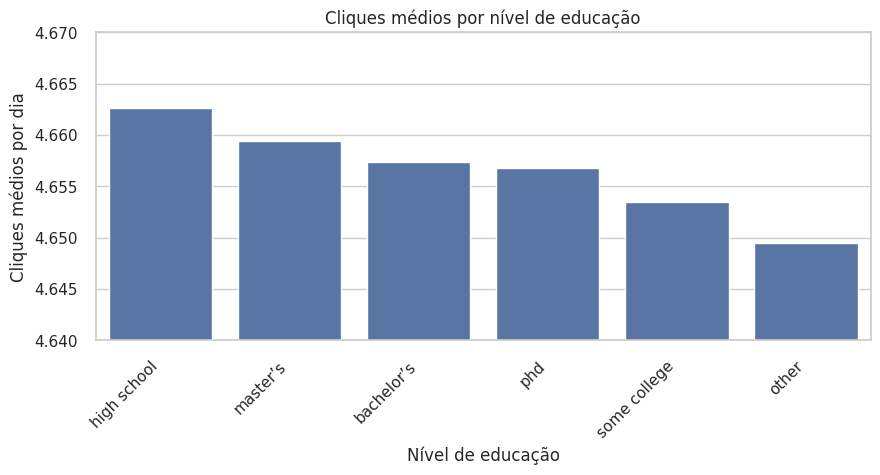

In [27]:
edu_stats = (
    df_silver.groupby("education_level")["ads_clicked_per_day"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

plt.figure(figsize=(10, 4))
sns.barplot(data=edu_stats, x="education_level", y="ads_clicked_per_day")
plt.xticks(rotation=45, ha="right")
plt.title("Cliques médios por nível de educação")
plt.xlabel("Nível de educação")
plt.ylabel("Cliques médios por dia")
plt.ylim(4.64, 4.67)
plt.show()

A análise dos cliques médios em anúncios por nível de educação evidencia a existência de **variação sistemática entre as categorias**, ainda que as diferenças absolutas sejam moderadas. Observa-se que usuários com níveis educacionais mais baixos apresentam, em média, valores ligeiramente superiores de cliques, enquanto níveis mais elevados tendem a concentrar médias um pouco menores. Esse comportamento sugere que o nível educacional pode estar associado a **padrões distintos de interação com anúncios**, possivelmente relacionados a diferenças no consumo de conteúdo, percepção de relevância ou sensibilidade a estímulos publicitários. Mesmo sem contrastes extremos, a ordenação consistente das barras indica que a variável carrega **informação analítica útil**.

Na camada Silver, onde o foco se desloca da limpeza estrutural para a avaliação do potencial explicativo das variáveis, esse gráfico contribui para a **validação da consistência dos dados tratados** e para a identificação de atributos que podem enriquecer análises multivariadas. Assim, o nível de educação se mostra uma variável **relevante para caracterização do perfil comportamental**, justificando sua permanência para etapas analíticas subsequentes.

## 15. Cliques vs estresse (barras por quartis)

A ideia é verificar se níveis de estresse se relacionam com comportamento de clique. Ao invés de dispersão, utilizamos quartis (Q1 a Q4), pois o agrupamento reduz ruído e produz uma tendência mais interpretável.

Valores crescentes de Q1 para Q4 indicam relação positiva (mais estresse, mais clique). Valores decrescentes indicam relação negativa (mais estresse, menos clique). Ambas as leituras são úteis, pois descrevem padrões comportamentais.


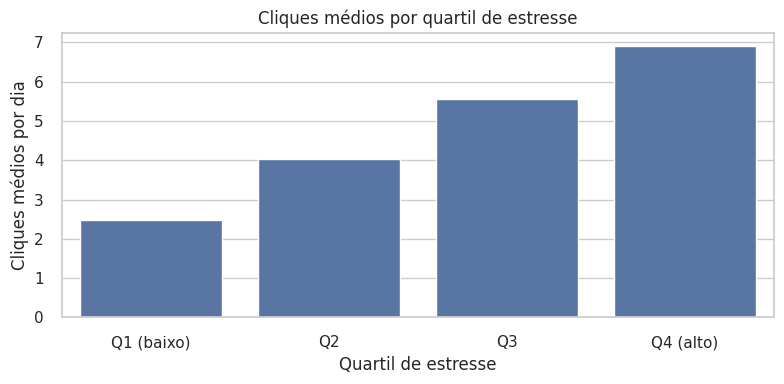

In [28]:
# Criação dos quartis de estresse
df_q = df_silver.copy()
df_q["stress_q"] = pd.qcut(
    df_q["perceived_stress_score"],
    4,
    labels=["Q1 (baixo)", "Q2", "Q3", "Q4 (alto)"]
)

# Média de cliques por quartil de estresse
stress_mean = (
    df_q
    .groupby("stress_q", observed=True)["ads_clicked_per_day"]
    .mean()
    .reset_index()
)

# Garantir ordem correta dos quartis
stress_mean["stress_q"] = pd.Categorical(
    stress_mean["stress_q"],
    categories=["Q1 (baixo)", "Q2", "Q3", "Q4 (alto)"],
    ordered=True
)
stress_mean = stress_mean.sort_values("stress_q")

# Gráfico
plt.figure(figsize=(8, 4))
sns.barplot(
    data=stress_mean,
    x="stress_q",
    y="ads_clicked_per_day"
)
plt.title("Cliques médios por quartil de estresse")
plt.xlabel("Quartil de estresse")
plt.ylabel("Cliques médios por dia")
plt.tight_layout()
plt.show()

A segmentação por quartis de estresse evidencia uma relação positiva clara: usuários com níveis mais elevados de estresse apresentam médias maiores de cliques. Essa variável demonstra forte relevância analítica e potencial explicativo do comportamento de engajamento.


## 16. Cliques vs felicidade (barras por quartis)

Esta análise replica a lógica por quartis, agora para felicidade auto-relatada. A intenção é identificar se bem-estar subjetivo possui associação com propensão a clicar em anúncios, novamente sem assumir causalidade.

Uma tendência crescente indica que usuários mais felizes clicam mais; uma tendência decrescente indica que usuários mais felizes clicam menos. Ambos os sentidos são informativos.


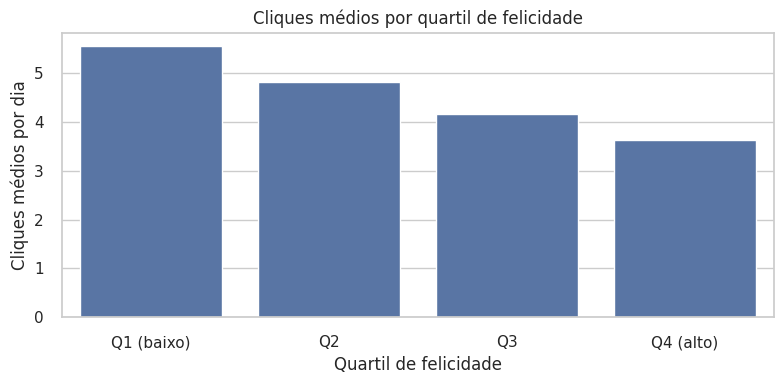

In [29]:
# Quartis de felicidade (sem warning e com ordem garantida)
df_q = df_silver.copy()
df_q["happy_q"] = pd.qcut(
    df_q["self_reported_happiness"],
    4,
    labels=["Q1 (baixo)", "Q2", "Q3", "Q4 (alto)"]
)

happy_mean = (
    df_q
    .groupby("happy_q", observed=True)["ads_clicked_per_day"]
    .mean()
    .reset_index()
)

# Garantir ordem Q1 -> Q4
happy_mean["happy_q"] = pd.Categorical(
    happy_mean["happy_q"],
    categories=["Q1 (baixo)", "Q2", "Q3", "Q4 (alto)"],
    ordered=True
)
happy_mean = happy_mean.sort_values("happy_q")

# Gráfico
plt.figure(figsize=(8, 4))
sns.barplot(
    data=happy_mean,
    x="happy_q",
    y="ads_clicked_per_day"
)
plt.title("Cliques médios por quartil de felicidade")
plt.xlabel("Quartil de felicidade")
plt.ylabel("Cliques médios por dia")
plt.tight_layout()
plt.show()

A análise por quartis de felicidade autorreferida indica uma relação inversa consistente com os cliques. Usuários menos satisfeitos apresentam maior média de cliques, enquanto usuários mais felizes demonstram menor propensão à interação com anúncios.


## 17. Resultado Final da Camada Silver

A análise realizada na camada Silver evidencia que, após o processo de transformação e padronização conduzido pelo ETL (Bronze → Silver), o dataset apresenta consistência estrutural e qualidade analítica adequadas para exploração do comportamento dos usuários em relação ao clique em anúncios. Diferentemente da camada Raw, cujo foco esteve na identificação de problemas estruturais, ruídos e necessidades de tratamento, a camada Silver permite uma leitura orientada ao **objetivo analítico do projeto**, centrado na caracterização do perfil comportamental dos usuários com maior propensão ao engajamento publicitário.

Os gráficos exploratórios demonstram que variáveis demográficas e socioeconômicas isoladas, como gênero, nível educacional e país, apresentam **variações reais, porém moderadas**, indicando que não são fatores determinantes individualmente, mas contribuem de forma incremental para a compreensão do fenômeno. Em especial, a análise por país revela diferenças consistentes entre as médias de cliques, sugerindo que o fator geográfico possui valor explicativo e não deve ser descartado na camada Silver, contrariando a hipótese inicial de irrelevância dessa variável.

Variáveis comportamentais e psicossociais, por sua vez, demonstram maior capacidade de diferenciação. O tempo de uso da plataforma (tempo em feed, reels e minutos ativos) apresenta correlação positiva com o número de cliques, reforçando a relação entre **exposição ao conteúdo e engajamento publicitário**. De forma complementar, a análise por quartis de estresse indica uma tendência crescente de cliques à medida que o nível de estresse aumenta, enquanto a felicidade autorrelatada apresenta relação inversa, com maiores médias de cliques concentradas nos quartis de menor felicidade.

A presença de filhos também se mostrou um fator relevante, com usuários que possuem filhos apresentando médias de cliques ligeiramente superiores. Embora a diferença seja sutil, ela se mantém consistente, indicando um possível impacto de contexto de vida e rotina sobre o comportamento de interação com anúncios.

De modo geral, a camada Silver confirma que o comportamento de clique não é explicado por uma única variável, mas por um **conjunto coerente de fatores comportamentais, psicossociais e contextuais**, cujos padrões tornam-se visíveis apenas após a padronização e organização dos dados.

### Conclusão Geral

A partir das análises conduzidas na camada Silver, conclui-se que o processo de tratamento dos dados foi bem-sucedido ao reduzir ruídos, eliminar inconsistências e preservar informações relevantes para a compreensão do fenômeno estudado. Os resultados indicam que o engajamento com anúncios está fortemente associado a **variáveis comportamentais e emocionais**, enquanto fatores demográficos atuam como moduladores secundários.

Usuários mais expostos à plataforma, com maior tempo de permanência e maior nível de estresse autorrelatado, tendem a apresentar maiores médias de cliques, ao passo que níveis mais elevados de felicidade estão associados a menor propensão ao engajamento publicitário. Esse padrão sugere que o clique em anúncios pode estar relacionado a estados emocionais e contextos de uso específicos, e não apenas a características estáticas do usuário.

Dessa forma, a camada Silver cumpre seu papel ao fornecer uma base analítica sólida, permitindo inferências comportamentais consistentes e orientando decisões futuras de modelagem, segmentação ou enriquecimento do dataset. Os achados obtidos justificam a manutenção das principais variáveis analisadas e indicam que o dataset está pronto para etapas posteriores, como a construção de modelos preditivos ou análises mais aprofundadas na camada Gold.